# Imports

In [109]:
import pandas
import pandas as pd
from pandas import MultiIndex, Int64Index
import numpy as np 
from pandas import MultiIndex, Int64Index
from copy import deepcopy
import time
from datetime import date
from tabulate import tabulate
import seaborn as sns
from selenium import webdriver
from tqdm import tqdm_notebook as tqdmn
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

from sklearn.pipeline import Pipeline
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity


from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV
from sklearn import tree
from sklearn.neighbors import LocalOutlierFactor

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from scipy.stats import chi2_contingency 
from scipy.stats import chi2


import warnings
warnings.filterwarnings("ignore")




# Data set info

In [110]:
df = pd.read_excel('houses.xlsx', index_col=0)

In [111]:
df.shape

(1331, 14)

In [112]:
df.head(5)

,State of the building,Number of facades,Habitable surface,Bedrooms,Bathrooms,Area of ​​the plot,Primary energy consumption,"Gas, water & electricity",Energy class,Heating type,Double glass,Price,Zip code,Township
6,To renovate,3,211,3,1,396,466.0,Yes,E,NaN,Yes,296000,9700,Oudenaarde
7,Excellent state,2,210,4,1,267,212.0,Yes,C,Gas,Yes,279000,9700,Oudenaarde
51,To renovate,3,280,4,2,880,576.0,No,G,Oil fuel,Yes,1350000,1060,Saint-Gilles
52,Good,2,180,4,1,182,358.0,Yes,D,Gas,NaN,399000,2000,Antwerpen
55,Good,2,105,2,1,336,247.0,Yes,C,Gas,Yes,279000,2000,Antwerpen


In [113]:
df.reset_index(inplace=True,drop=True)

In [114]:
mynewcolumns= ['State', 'Facades','Surface','Bedrooms','Bathrooms','Plot_area',
 'Prime_energy','Utilities','Energy_class','Heating','Double_glass','Price','Zip','Township']
mynewindex= [ 'State', 'Facades','Bedrooms','Bathrooms','Utilities','Energy_class',
 'Heating','Double_glass','Zip','Township','Surface','Plot_area', 'Prime_energy','Price']

In [115]:
df.columns = mynewcolumns
df = df[mynewindex]

In [116]:
df.dtypes

State            object
Facades           int64
Bedrooms          int64
Bathrooms         int64
Utilities        object
Energy_class     object
Heating          object
Double_glass     object
Zip               int64
Township         object
Surface           int64
Plot_area         int64
Prime_energy    float64
Price             int64
dtype: object

In [117]:
cat_vars = []
cont_vars = []
columns = list(df.drop(columns = ['Township','Zip']).columns)

In [118]:
cat_vars

[]

In [119]:
# cat_vars = []
# cont_vars = []
# columns = list(df.drop(columns = ['Township','Zip']).columns)
for i in columns:
    if (len(df.loc[:,i].unique()) >= 20):
        cont_vars.append(i)
    else:
        cat_vars.append(i)
cat_vars.append('Township')
cat_vars.append('Zip')
print('Continious variables are:',cont_vars)
print('------------------')
print('Categorical variables are:',cat_vars)
# Here we have our list of categorical and continious variables

Continious variables are: ['Surface', 'Plot_area', 'Prime_energy', 'Price']
------------------
Categorical variables are: ['State', 'Facades', 'Bedrooms', 'Bathrooms', 'Utilities', 'Energy_class', 'Heating', 'Double_glass', 'Township', 'Zip']


In [120]:
df.head(5)

,State,Facades,Bedrooms,Bathrooms,Utilities,Energy_class,Heating,Double_glass,Zip,Township,Surface,Plot_area,Prime_energy,Price
0,To renovate,3,3,1,Yes,E,NaN,Yes,9700,Oudenaarde,211,396,466.0,296000
1,Excellent state,2,4,1,Yes,C,Gas,Yes,9700,Oudenaarde,210,267,212.0,279000
2,To renovate,3,4,2,No,G,Oil fuel,Yes,1060,Saint-Gilles,280,880,576.0,1350000
3,Good,2,4,1,Yes,D,Gas,NaN,2000,Antwerpen,180,182,358.0,399000
4,Good,2,2,1,Yes,C,Gas,Yes,2000,Antwerpen,105,336,247.0,279000


In [121]:
df.isna().sum(axis=0).reset_index()

,index,0
0,State,0
1,Facades,0
2,Bedrooms,0
3,Bathrooms,0
4,Utilities,0
5,Energy_class,0
6,Heating,228
7,Double_glass,223
8,Zip,0
9,Township,0


## Web Scraping for coordinates & Provinces

I am aware that it was available in the Excel sheet. I did this for self-learning.

In [122]:
#Group zip and country together
df['Belgium'] = 'Belgium'
df['Zip'] = df['Zip'].apply(lambda x: str(x))
df['Full_Address'] = df['Zip'].str.cat(df[['Belgium']], sep=', ')
df['Full_Address'] = df['Full_Address'].apply(lambda x: str(x))
df.drop('Belgium', axis=1,inplace=True)

In [123]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="example app")

In [124]:
df['Zip'] =df['Zip'].astype(int) 

In [125]:
# # Import library
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="example app")

# #Get unique values to save computation time
# lat=[]
# long=[]
# province=[]
# for x in unique(df.Full_Address.values):
#     print(x)
#     long.append(geolocator.geocode(x).longitude)
#     lat.append(geolocator.geocode(x).latitude)
#     province.append(geolocator.geocode(x).raw['display_name'].partition(',')[-1].split()[0])
# #Create table
# coords = pd.DataFrame(list(zip(lat, long, province)),
#                columns =['Latitude', 'Longitude','Province'])

# #Export to excel
# coords.to_excel('houses_withcoords.xlsx', index=False)

In [126]:
coords=pd.read_excel('houses_withcoords.xlsx')

In [127]:
df = pd.merge(df, coords,left_on='Full_Address' ,right_on="Full_Address")

We can add the provinces depending on the Zip code

In [128]:
def get_province(x):
    if x < 1300:
        return "Brussels-Capital"
    elif x < 1500:
        return "Walloon Brabant"
    elif x < 2000:
        return "Flemish Brabant"
    elif x < 3000:
        return "Antwerp"
    elif x < 3500:
        return "Flemish Brabant"
    elif x < 4000:
        return "Limburg"
    elif x < 5000:
        return "Liège"
    elif x < 6000:
        return "Namur"
    elif x < 6600:
        return "Hainaut"
    elif x < 7000:
        return "Luxembourg"
    elif x < 8000:
        return "Hainaut"
    elif x < 9000:
        return "West Flanders"
    else:
        return 'East Flanders'
def get_longitude(x):
    if x == "Brussels-Capital":
        return 4.3802
    elif x == "Walloon Brabant":
        return 4.5243
    elif x == "Flemish Brabant":
        return 4.5646
    elif x == "Antwerp":
        return 4.4051
    elif x == "Flemish Brabant":
        return 4.5646
    elif x == "Limburg":
        return 5.3420
    elif x == "Liège":
        return 5.5697
    elif x == "Namur":
        return 4.8651
    elif x == "Hainaut":
        return 4.0621
    elif x == "Luxembourg":
        return 6.1296
    elif x == "Hainaut":
        return 4.0621
    elif x == "East Flanders":
        return 3.7373
    else:
        return 3.1458
def get_latitude(x):
    if x == "Brussels-Capital":
        return 50.8260
    elif x == "Walloon Brabant":
        return 50.6332
    elif x == "Flemish Brabant":
        return 50.8815
    elif x == "Antwerp":
        return 51.2213
    elif x == "Flemish Brabant":
        return 50.8815
    elif x == "Limburg":
        return 50.9739
    elif x == "Liège":
        return 50.6330
    elif x == "Namur":
        return 50.4649
    elif x == "Hainaut":
        return 50.5257
    elif x == "Luxembourg":
        return 49.8153
    elif x == "Hainaut":
        return 50.5257
    elif x == "East Flanders":
        return 51.0362
    else:
        return 51.0536

In [129]:
df['Province'] = df['Zip'].apply(get_province)

In [130]:
df['Province_lat'] = df['Province'].apply(get_latitude)
df['Province_lon'] = df['Province'].apply(get_longitude)

In [131]:
df.drop(['Zip','Full_Address'],axis=1,inplace=True)
df = df[['State', 'Facades', 'Bedrooms', 'Bathrooms', 'Utilities',
       'Energy_class', 'Heating', 'Double_glass', 'Province', 'Township','Longitude','Latitude','Province_lon','Province_lat',
         'Surface',   'Plot_area', 'Prime_energy', 'Price']]

In [132]:
df

,State,Facades,Bedrooms,Bathrooms,Utilities,Energy_class,Heating,Double_glass,Province,Township,Longitude,Latitude,Province_lon,Province_lat,Surface,Plot_area,Prime_energy,Price
0,To renovate,3,3,1,Yes,E,NaN,Yes,East Flanders,Oudenaarde,3.606160,50.848474,3.7373,51.0362,211,396,466.0,296000
1,Excellent state,2,4,1,Yes,C,Gas,Yes,East Flanders,Oudenaarde,3.606160,50.848474,3.7373,51.0362,210,267,212.0,279000
2,Excellent state,4,3,1,Yes,B,Gas,Yes,East Flanders,Oudenaarde,3.606160,50.848474,3.7373,51.0362,253,3090,164.0,644500
3,Good,4,3,1,Yes,F,Gas,Yes,East Flanders,Oudenaarde,3.606160,50.848474,3.7373,51.0362,262,1080,572.0,455000
4,To renovate,2,3,2,Yes,D,Gas,No,East Flanders,Oudenaarde,3.606160,50.848474,3.7373,51.0362,170,384,370.0,199000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,Excellent state,2,2,1,Yes,F,Gas,Yes,Hainaut,Ecaussinnes,4.167075,50.566535,4.0621,50.5257,146,125,464.0,149000
1327,Excellent state,2,3,1,Yes,A,Gas,Yes,East Flanders,Nieuwerkerken,4.036590,50.926880,3.7373,51.0362,140,330,96.0,299000
1328,Good,4,2,1,Yes,D,Gas,Yes,Hainaut,Estaimpuis,3.283499,50.687742,4.0621,50.5257,164,800,323.0,289000
1329,Good,2,3,1,Yes,F,Gas,NaN,West Flanders,Diksmuide,2.870591,51.059085,3.1458,51.0536,226,172,557.0,260000


# Explanatory Data Analysis

## Quick clean up before exploration and splitting

In [133]:
## Change the plot area = to surface if livable surface is greater than plot area
df['Surface_Ratio']  = df['Surface'] / df['Plot_area'] 
df['Surface_Ratio'] = df['Surface_Ratio'].apply(lambda x: round(x,2)*100)
df['Plot_area'] = np.where(df['Plot_area']<df['Surface'], df['Surface'], df['Plot_area'])

In [134]:
#Impute missing values
df["Double_glass"] = df["Double_glass"].fillna("None")
df["Heating"] = df["Heating"].fillna("None")

In [135]:
# # Change the energy classes to letters only
# df['Energy_class'].replace({'A+':'A','E_D':'E','D_C':'C'}, inplace=True)

In [136]:
df.isna().sum(axis=0).reset_index()

,index,0
0,State,0
1,Facades,0
2,Bedrooms,0
3,Bathrooms,0
4,Utilities,0
5,Energy_class,0
6,Heating,0
7,Double_glass,0
8,Province,0
9,Township,0


In [137]:
X = df.drop('Price', axis=1)
y = df['Price']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10,shuffle=True)

In [139]:
X_train['Price'] = y_train

In [140]:
df = X_train.copy()
df.reset_index(inplace=True,drop=True)

## Exploring sample sizes within each category

In [141]:
# convert price to thousands for easier graph readings
df['Price'] = df['Price'].apply(lambda x: x/1000)

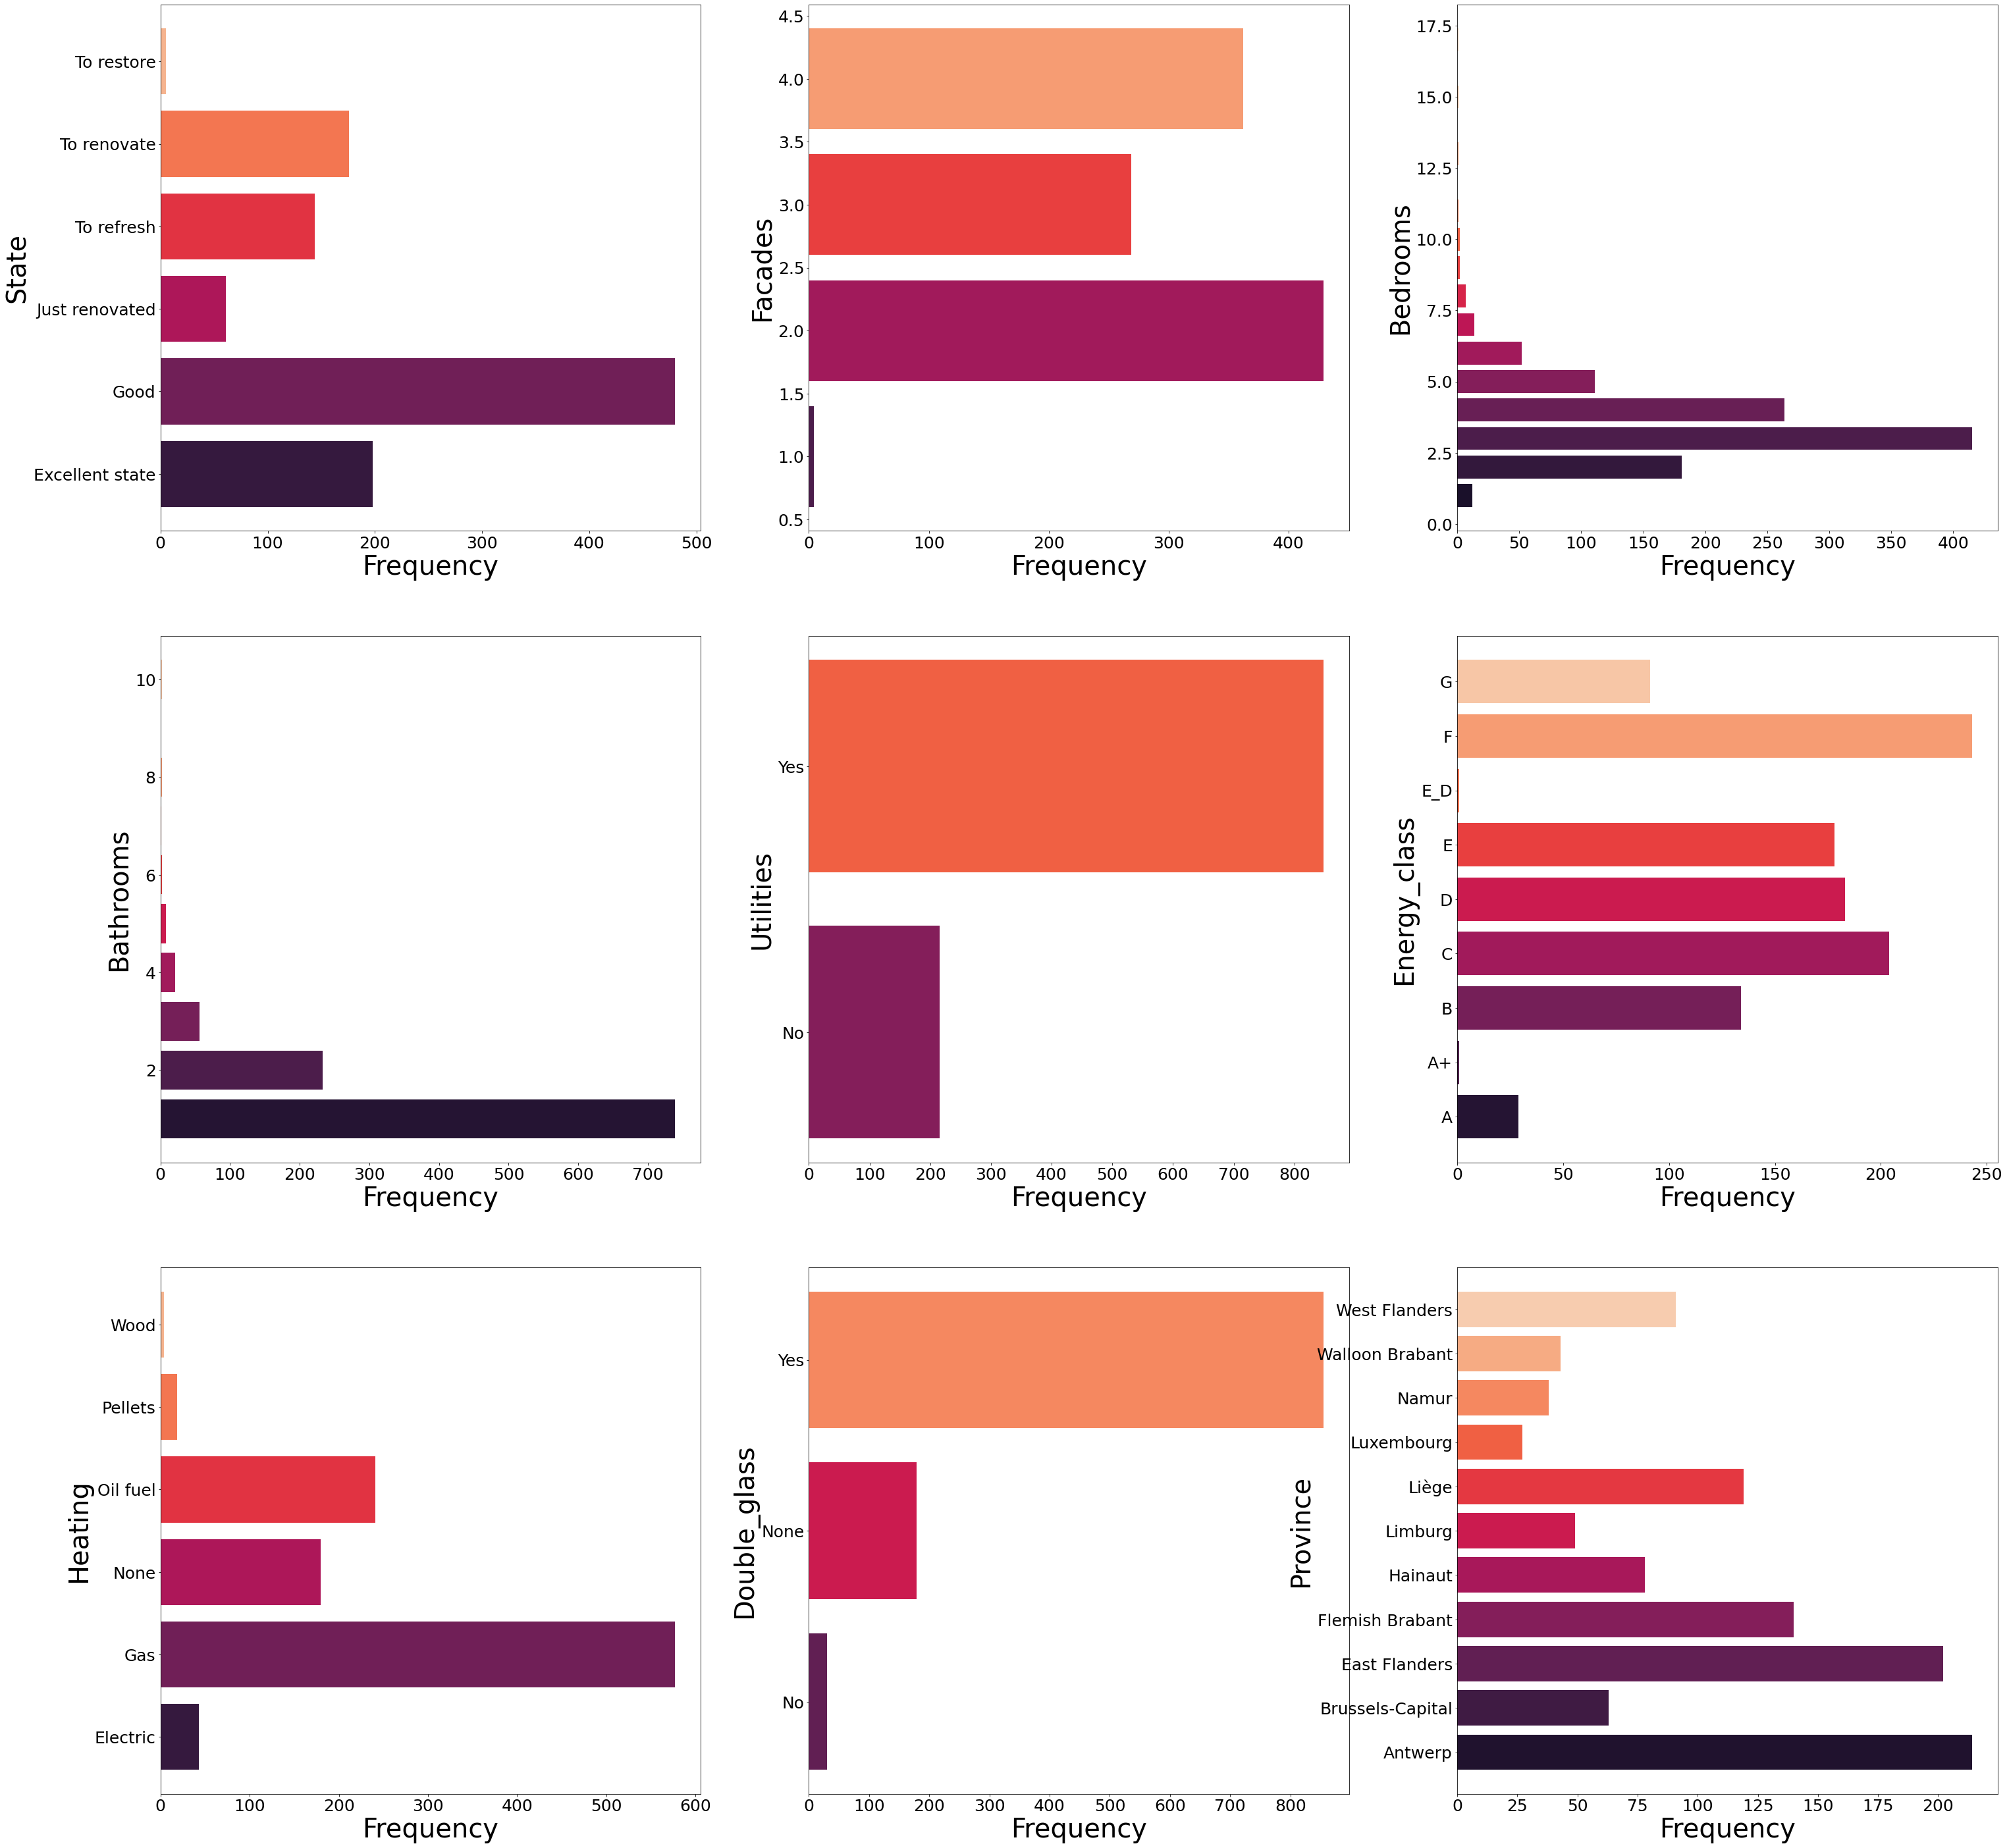

In [142]:
cat_vars=df.columns[0:9]
fig, axes = plt.subplots(3, 3, figsize=(50, 50))
i = 0
j = 0

for x in cat_vars:
    df_copy =df.copy()
    df_copy = df_copy.groupby(x,as_index=True)[x].agg(count = ('size'))
    df_copy= df_copy.reset_index()
    colors=(df[x].nunique())
    
    axes[i, j].set_ylabel(x, fontsize=40)
    axes[i, j].set_xlabel('Frequency',fontsize=40)
    axes[i, j].barh(df_copy[x],df_copy['count'],color=sns.color_palette("rocket",n_colors=colors))
    axes[i,j].tick_params(axis='both', which='major', labelsize=25)
    j = j + 1
    if (j > 2):
        j = 0
        i = i + 1
    

Features with imbalanced data set: 
- **Double Glass**: No
- **Energy_class**: A+, E_D
- **Heating**: Wood, pellets, Electric
- **Bathrooms**: 4+
- **State**: To restore
- **Facades**: 1 Facade
- **Bedrooms**: 7 and plus
- **Utilities**: No

## Exploring through maps

**By Province:**

In [143]:
location_stats = df.groupby(['Province','Province_lat','Province_lon'],as_index=True).agg(count = ('Township','size'),mean=('Price','mean'))
location_stats = location_stats.reset_index()
fig = px.scatter_geo(location_stats[location_stats['count']>0], lat='Province_lat', lon='Province_lon', 
                     color="mean", size="mean", 
                     
                     hover_name="Province",
                     projection="natural earth",
                    scope='europe'
                     # projection="orthographic"
                     )


fig.show()

The most expensive provinces on average are: **Brussels-Capital, Walloon & Flemish Brabant, and Antwerp.**

**By Town > 10houses:**

Let's see the average price per town for the towns with more than 3 houses to get a realistic average.

In [144]:
location_stats = df.groupby(['Township','Latitude','Longitude'],as_index=True).agg(count = ('Township','size'),mean=('Price','mean'))
location_stats = location_stats.reset_index()
fig = px.scatter_geo(location_stats[location_stats['count']>10], lat='Latitude', lon='Longitude', 
                     color="mean", size="mean", 
                     
                     hover_name="Township",
                     projection="natural earth",
                    scope='europe'
                     # projection="orthographic"
                     )

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.show()

The most expensive cities on average are: **Uccle, Ixelle, Woluwe St Lambert, Brasschaat**.

**All Towns:**

In [145]:
location_stats = df.groupby(['Township','Latitude','Longitude'],as_index=True).agg(count = ('Township','size'),mean=('Price','mean'))
location_stats = location_stats.reset_index()
fig = px.scatter_geo(location_stats[location_stats['count']>0], lat='Latitude', lon='Longitude', 
                     color="mean", size="mean", 
                     
                     hover_name="Township",
                     projection="natural earth",
                     scope='europe'
                    
                     # projection="orthographic"
                     )

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.show()

As we expand and move away from the center and north of beglium, house prices tend to fall in general.

**By Energy Class:**

In [146]:
location_stats = df.groupby(['Energy_class','Latitude','Longitude'],as_index=True)

In [147]:
df['Price'] = df['Price'].apply(lambda x: x*1000)

By changing the color parameter, I can visualize each categorical factor on the map.

In [149]:
fig = px.scatter_geo(df, lat='Latitude', lon='Longitude', 
                     color="Energy_class",
                     color_discrete_map={
                         'A+':'#477EF3',
                         'A':'#26F92A',
                         'B':'#79CA58',
                         'C':'#ADDF39',
                         'D':'#F3F347   ',
                         'E':'#F8A83C',
                         'F':'#EE721C',
                         'G':'#F31511',
                     } ,
                      size="Price",
                     scope='europe',
                     projection="natural earth"
                     # projection="orthographic"
                     )
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True,resolution=50,
    showcoastlines=True, 
    showland=True,
    showocean=True, oceancolor="LightBlue"
    )
# fig.update_layout(height=600, margin={"r":900,"t":0,"l":0,"b":0})
# fig.show()

We don't see any segreggation geographically when it comes to Energy class nor the marginal price change for each class.

In [42]:
location_stats = df.groupby(['Township','Double_glass','Latitude','Longitude'],as_index=True).agg(count = ('Township','size'),mean=('Price','mean'))
location_stats = location_stats.reset_index()
fig = px.scatter_geo(location_stats[location_stats['count']>0], lat='Latitude', lon='Longitude', 
                     color="Double_glass", size="mean", 
                     
                     hover_name="Township",
                     projection="natural earth",
                     scope='europe'
                    
                     # projection="orthographic"
                     )

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.show()

No geographical seggreation for double glassed windows

In [150]:
location_stats = df.groupby(['Township','Heating','Latitude','Longitude'],as_index=True).agg(count = ('Township','size'),mean=('Price','mean'))
location_stats = location_stats.reset_index()
fig = px.scatter_geo(location_stats[location_stats['count']>0], lat='Latitude', lon='Longitude', 
                     color="Heating", size="mean", 
                     
                     hover_name="Township",
                     projection="natural earth",
                     scope='europe'
                    
                     # projection="orthographic"
                     )

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True,resolution=50,
    showcoastlines=True, 
    showland=True,
    showocean=True, oceancolor="LightBlue"
    )
# fig.update_layout(height=600, margin={"r":900,"t":0,"l":0,"b":0})
# fig.show()

## Categorical variables EDA

### Statistical Analysis 

In [44]:
cat_vars= df[['State', 'Facades', 'Bedrooms', 'Bathrooms','Utilities', 'Energy_class', 'Heating', 'Double_glass','Province','Township']]
for var in cat_vars:
    df[var] = pd.Categorical(df[var]) 
   

In [45]:
remove_cat = []
keep_cat=[]
for x in cat_vars:
    test = pd.crosstab(df['Price'],df[x],margins = False)
    stat, p, dof, expected = chi2_contingency(test)
    critical = chi2.ppf(0.95, dof)
    if abs(stat) >= critical:
        keep_cat = keep_cat + [x]
        print(x + ': Dependent (reject H0) p-value:' + str(round(p,5)))
    else:
        remove_cat = remove_cat + [x]
        print(x + ': Independent (fail to reject H0)p-value:' + str(round(p,5)))

State: Dependent (reject H0) p-value:0.04231
Facades: Dependent (reject H0) p-value:0.00147
Bedrooms: Dependent (reject H0) p-value:0.0
Bathrooms: Dependent (reject H0) p-value:0.0
Utilities: Independent (fail to reject H0)p-value:0.86433
Energy_class: Dependent (reject H0) p-value:0.0
Heating: Independent (fail to reject H0)p-value:0.67021
Double_glass: Independent (fail to reject H0)p-value:0.99635
Province: Dependent (reject H0) p-value:6e-05
Township: Independent (fail to reject H0)p-value:1.0


### Boxplots

In [46]:
cat_vars=df.copy()

    

In [47]:
cat_vars.columns[0:9]

Index(['State', 'Facades', 'Bedrooms', 'Bathrooms', 'Utilities',
       'Energy_class', 'Heating', 'Double_glass', 'Province'],
      dtype='object')

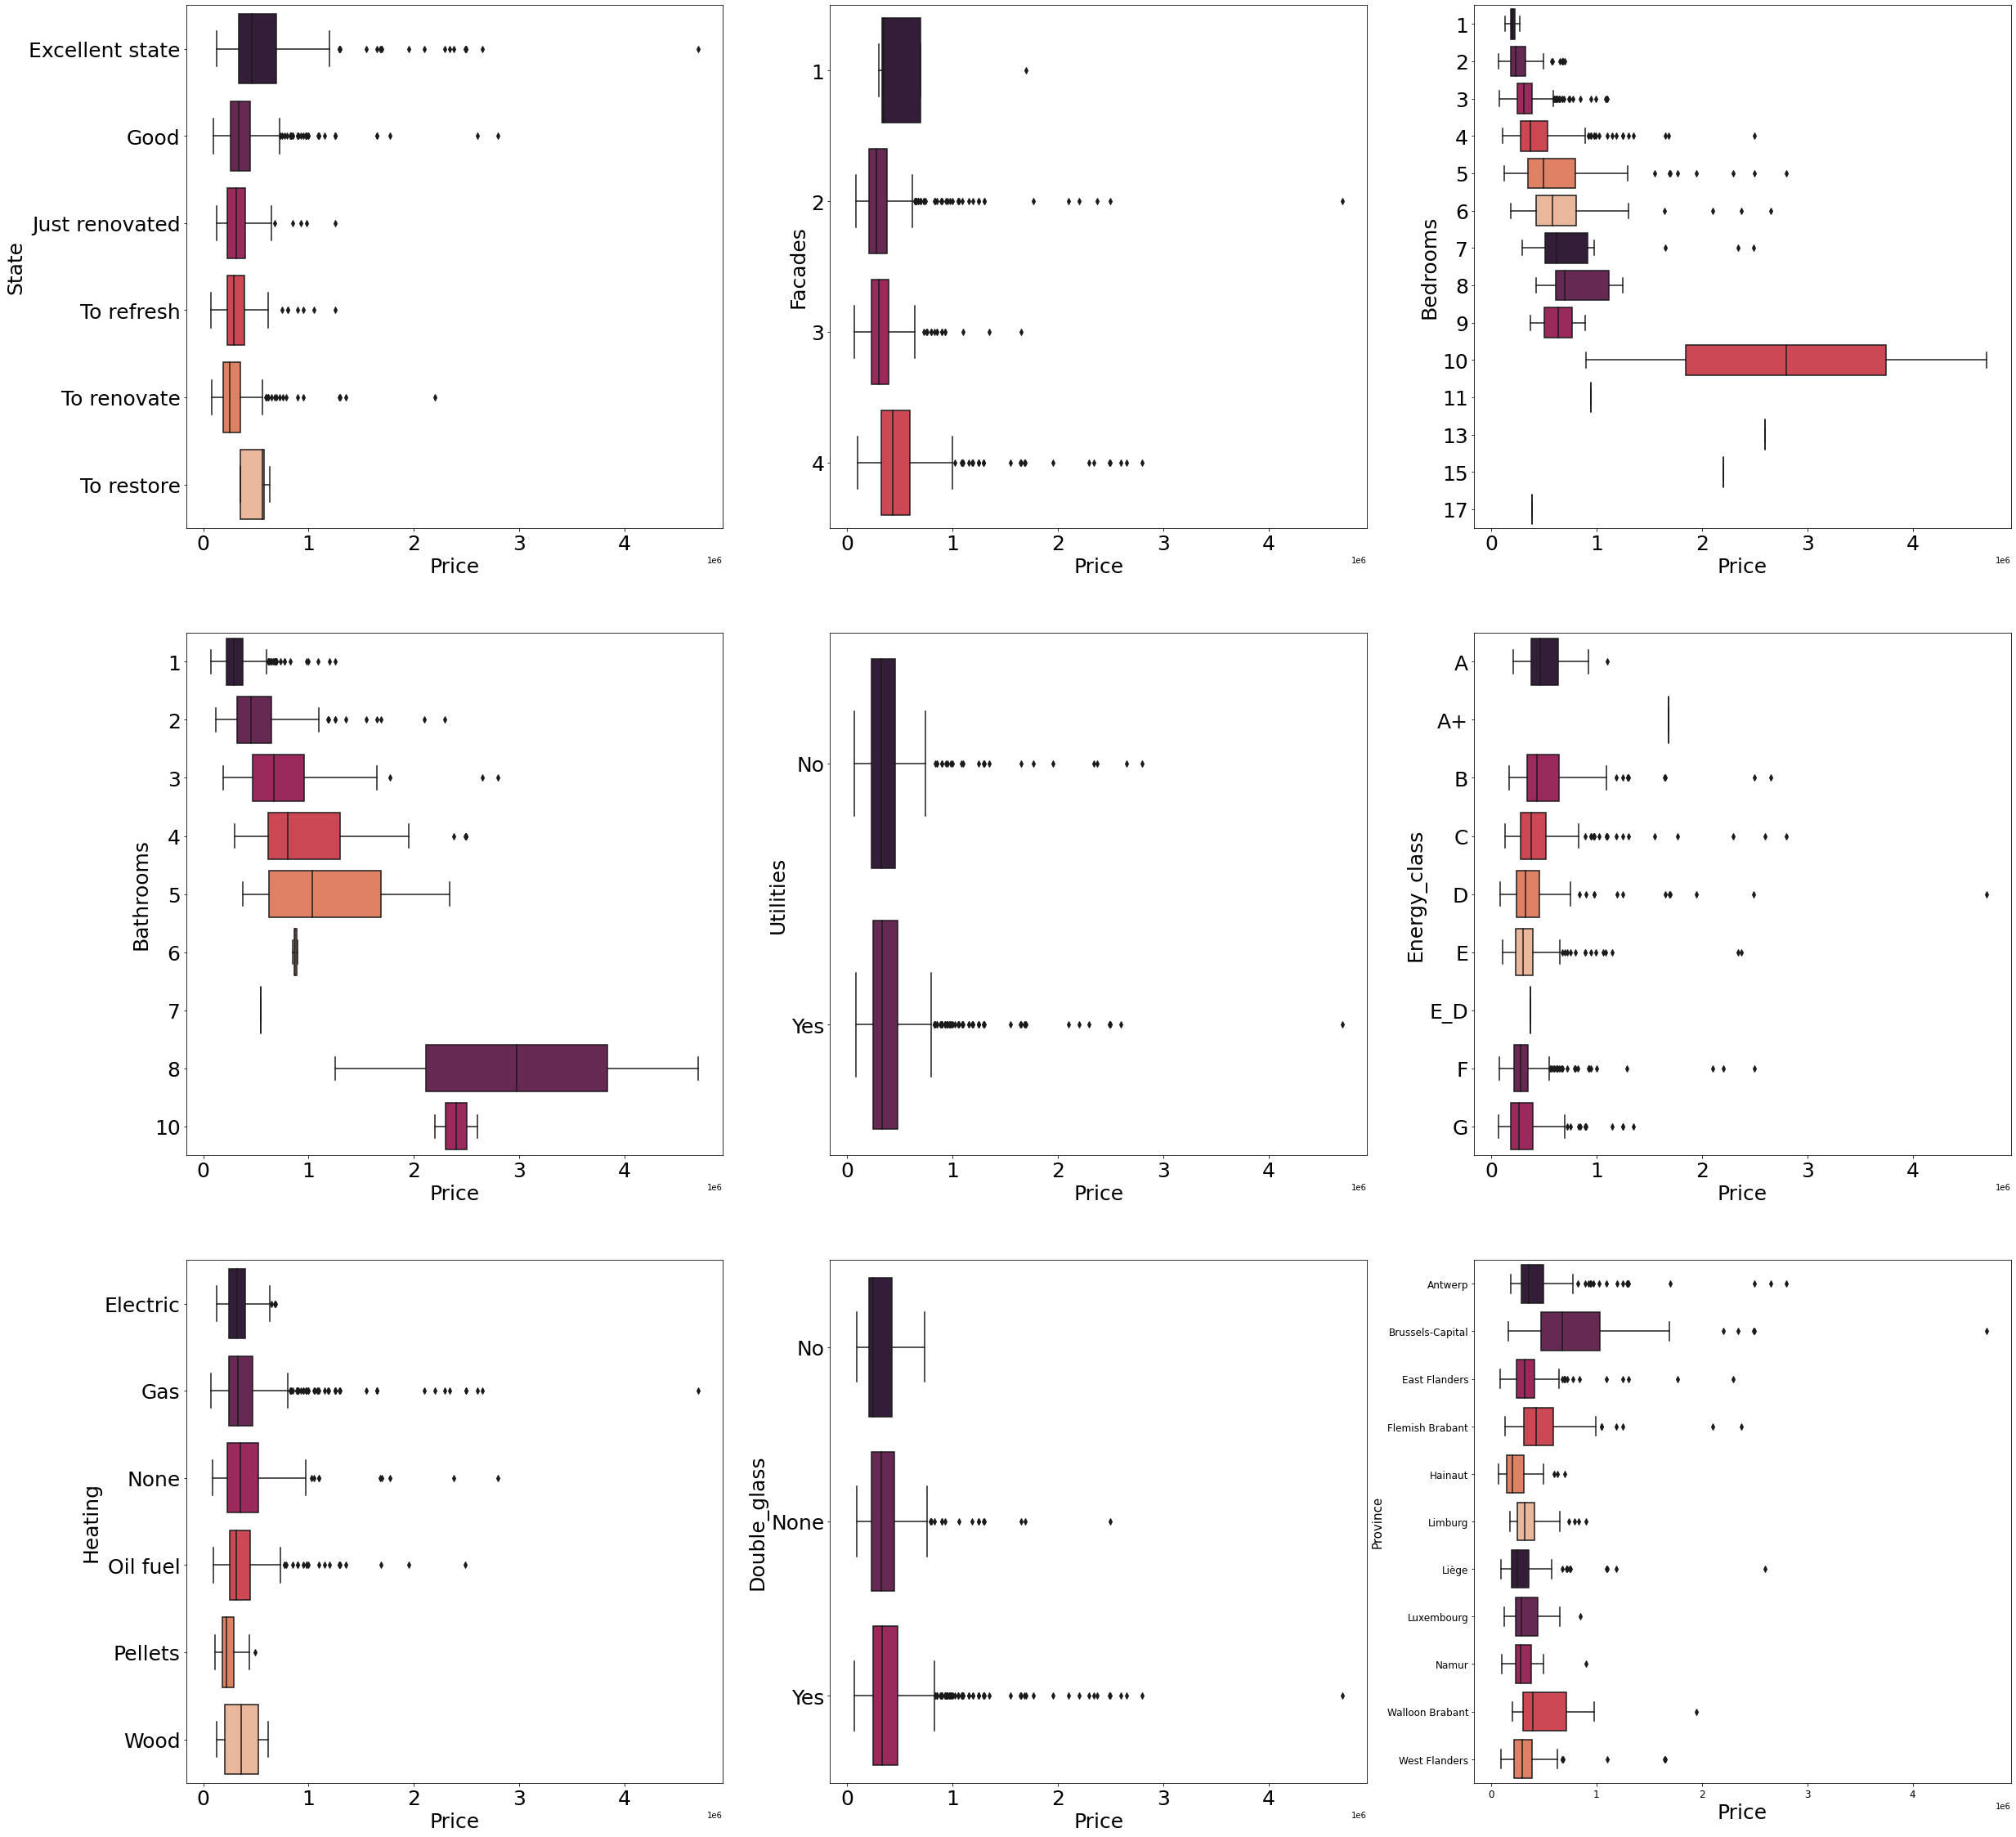

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(40,40))

i = 0
j = 0
for variable in cat_vars.columns[0:9]:
    if variable!=cat_vars.columns[8]:
        plot = sns.boxplot(ax=axes[i, j],data=df, x="Price", y =variable ,orient='h' ,palette=sns.color_palette('rocket'))
        axes[i, j].set_ylabel(variable, fontsize=25)
        axes[i, j].set_xlabel('Price',fontsize=25)
        axes[i,j].tick_params(axis='both', which='major', labelsize=25)
        j = j + 1
        if (j > 2):
            j = 0
            i = i + 1
    else:
        plot = sns.boxplot(ax=axes[i, j],data=df, x="Price", y =variable ,orient='h' ,palette=sns.color_palette('rocket'))
        axes[i, j].set_ylabel(variable, fontsize=15)
        axes[i, j].set_xlabel('Price',fontsize=25)
        axes[i,j].tick_params(axis='both', which='major', labelsize=12)


- **State**: We can see a decline in Price when state of the house decreases. However, we should see that the prices of houses *To restore* to drop lower than the houses *To renovate*. We will take a deeper look at that later. 
- **Facades**: We are seeing an increase price as number of facades increases, except for houses with 1 facade because we have only one observation.
- **Bedrooms**: Price > as Bedrooms >, but for houses with more than 6 bedrooms, their prices are not definitive because we barely have observations.
- **Bathrooms**: Same as above.

- **Heating**: was stated not to be statistically significant. We could see from the boxplot that Wood, Electric, Oil and Gas heating are about the same price. Where Pellets and coal are cheaper. 
- **Utilities**: doesn't seem to affect price at all and no statistical significance.
- **Double_glass**: same as *Utilities*

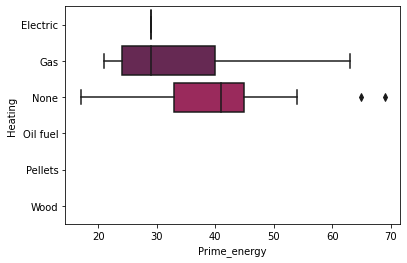

In [49]:
plot = sns.boxplot(data=df[df['Prime_energy']<75], x="Prime_energy", y ='Heating' ,orient='h' ,palette=sns.color_palette('rocket'))

Text(0, 0.5, 'Energy Consumption')

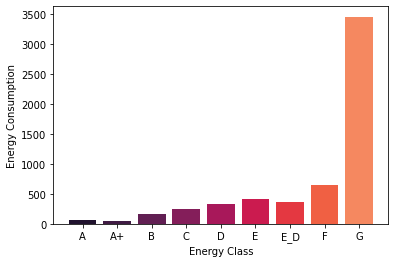

In [50]:
df_copy =df.copy()
df_copy = df_copy.groupby('Energy_class',as_index=True)['Prime_energy'].agg(mean = ('mean'))
df_copy= df_copy.reset_index()
plt.bar(df_copy['Energy_class'],df_copy['mean'],color=sns.color_palette("rocket",n_colors=colors))
plt.xlabel('Energy Class')
plt.ylabel('Energy Consumption')

As the energy class gets degraded, the amount of energy in kWh increases.

## Numerical variables EDA

The correlation matrix suggests high correlation between the numerical and target variable except for prime energy. That is interesting to note since prime energy is correlated with Energy class, and we concluded from the the pearson chi square test that it is statistically significant.

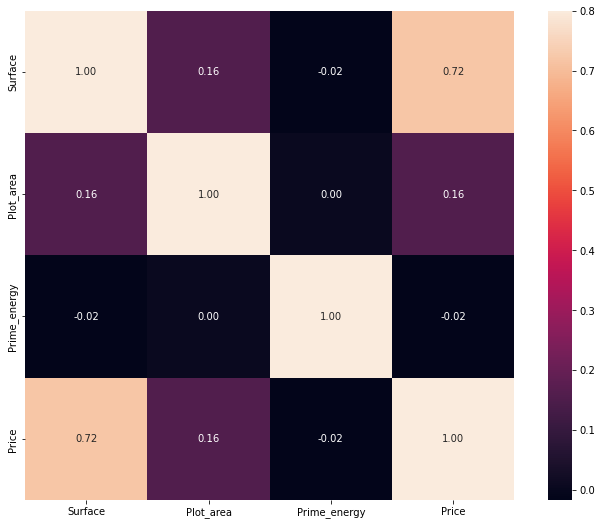

In [51]:
# Correlation Matrix for numerical variables
corrmat = df[['Surface','Plot_area','Prime_energy','Price']].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f');
plt.show()

# Feature Engineering 

## Feature Engineering

### Feature Engineering 1: Price per sqm

In [157]:
df['price_per_sqm'] = round(df['Price']/df['Plot_area'])

In [158]:
location_stats = df.groupby(['Province'],as_index=True).agg(mean=('price_per_sqm','mean'))
location_stats = pd.merge(location_stats, df,left_on='Province' ,right_on="Province")

In [159]:

fig = px.scatter_geo(location_stats, lat='Province_lat', lon='Province_lon', 
                     color="mean", size="mean", 
                     
                     hover_name="Province",
                     projection="natural earth",
                    scope='europe'
                     # projection="orthographic"
                     )

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.show()

### Feature Engineering 2: Taxes per province

In [160]:
df['Tax_immobilier'] = df['Province'].apply(lambda x: 0.025 if x in ['Flemish Brabant', 'West Flanders', 'East Flanders', 'Antwerp' , 'Limburg'] else 0.0225 if x =='Brussels-Capital' else 0.01 if x=='Luxembourg' else 0.0125)

### Feature Engineering 3: Distance from capital

In [161]:
df['LAT_rad'], df['LON_rad'] = np.radians(df['Latitude']), np.radians(df['Longitude'])
df['dLON'] = df['LON_rad'] - np.radians(4.371904)
df['dLAT'] = df['LAT_rad'] - np.radians(50.825649)
df['Distance']=6367 * 2 * np.arcsin(np.sqrt( np.sin(df['dLAT'] / 2)**2 + np.cos(df['LAT_rad']) * np.cos(50.825649) * np.sin(df['dLON']/ 2)**2))
df['Distance'] = df['Distance'].apply(lambda x: round(x,2))

In [162]:
df.columns

Index(['State', 'Facades', 'Bedrooms', 'Bathrooms', 'Utilities',
       'Energy_class', 'Heating', 'Double_glass', 'Province', 'Township',
       'Longitude', 'Latitude', 'Province_lon', 'Province_lat', 'Surface',
       'Plot_area', 'Prime_energy', 'Surface_Ratio', 'Price', 'price_per_sqm',
       'Tax_immobilier', 'LAT_rad', 'LON_rad', 'dLON', 'dLAT', 'Distance'],
      dtype='object')

In [163]:
df.drop(['Longitude','Latitude','LAT_rad','LON_rad', 'dLON', 'dLAT'], axis=1, inplace=True)

### Feature Engineering 4: Livable/Plot surface ratio

It was added in the beginning to impute rows where plot area is smaller than livable surface.

In [164]:
#df['Surface_Ratio'] = df['Surface_Ratio'].apply(lambda x: round(x,2))

## Data pre-processing

Remove unnecessary columns based on statistical analysis conducted.

In [165]:
df.drop(['Township', 'Double_glass', 'Utilities', 'Heating','Prime_energy',
         'Province_lon', 'Province_lat','price_per_sqm'],axis=1, inplace=True)

In [166]:
# Change the energy classes to letters only
df['Energy_class'].replace({'A+':'A','E_D':'E','D_C':'C'}, inplace=True)

In [167]:
mapper1 = {'A':6 , 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
mapper2 = {'Excellent state':5 , 'Good': 4, 'Just renovated': 3, 'To refresh': 2, 'To renovate': 1, 'To restore': 0}

df['Energy_class'].replace(mapper1, inplace=True)
df['State'].replace(mapper2, inplace=True)

In [168]:
df = pd.get_dummies(df, columns=['Province'],drop_first=True)

In [169]:
final_df = df.copy()

----------------

In [170]:
X_test.drop(['Township', 'Double_glass', 'Utilities', 'Heating', 'Prime_energy',
         'Province_lon', 'Province_lat'],axis=1, inplace=True)
X_test['Energy_class'].replace({'A+':'A','E_D':'E','D_C':'C'}, inplace=True)
X_test['Energy_class'].replace(mapper1, inplace=True)
X_test['State'].replace(mapper2, inplace=True)
X_test['Tax_immobilier'] = X_test['Province'].apply(lambda x: 0.025 if x in ['Flemish Brabant', 'West Flanders', 'East Flanders', 'Antwerp' , 'Limburg'] else 0.0225 if x =='Brussels-Capital' else 0.01 if x=='Luxembourg' else 0.0125)
X_test['LAT_rad'], X_test['LON_rad'] = np.radians(X_test['Latitude']), np.radians(X_test['Longitude'])
X_test['dLON'] = X_test['LON_rad'] - np.radians(4.371904)
X_test['dLAT'] = X_test['LAT_rad'] - np.radians(50.825649)
X_test['Distance']=6367 * 2 * np.arcsin(np.sqrt( np.sin(X_test['dLAT'] / 2)**2 + np.cos(X_test['LAT_rad']) * np.cos(50.825649) * np.sin(X_test['dLON']/ 2)**2))
X_test['Distance'] = X_test['Distance'].apply(lambda x: round(x,2))
X_test.drop(['Longitude','Latitude','LAT_rad','LON_rad', 'dLON', 'dLAT'], axis=1, inplace=True)

In [171]:
X_test = pd.get_dummies(X_test, columns=['Province'],drop_first=True)

## Price Distribution

The price distribution looks like the following:


 mu = 421642.31 and sigma = 349660.43



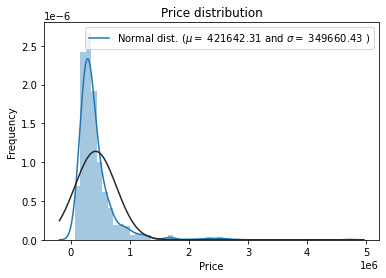

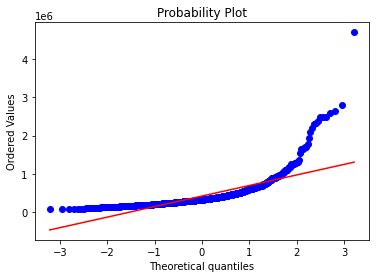

In [172]:
sns.distplot(df['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Price'], plot=plt)
plt.show()

In [177]:
df.columns

Index(['State', 'Facades', 'Bedrooms', 'Bathrooms', 'Energy_class', 'Surface',
       'Plot_area', 'Surface_Ratio', 'Price', 'Tax_immobilier', 'Distance',
       'Province_Brussels-Capital', 'Province_East Flanders',
       'Province_Flemish Brabant', 'Province_Hainaut', 'Province_Limburg',
       'Province_Liège', 'Province_Luxembourg', 'Province_Namur',
       'Province_Walloon Brabant', 'Province_West Flanders'],
      dtype='object')

Since linear regression assumes linear relationship between input and output variable, it is necessary to use log transformation.

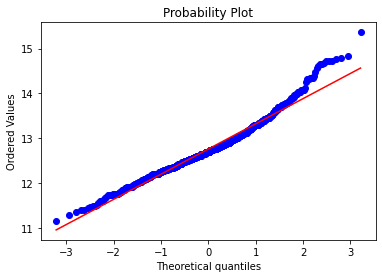

In [174]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log(df['Price']), plot=plt)
plt.show()

After power transforming the target variable, the variance stabilized more. We will use the log transformed target variable to detect outliers

## Outlier Detection

In [175]:
X = df.copy()
X['Price'] = np.log(X['Price'])
std = StandardScaler()
X = std.fit_transform(X.drop('Price',axis=1), y=X['Price'])
pca = PCA(n_components=2).fit_transform(X)
pca = pd.DataFrame(pca)

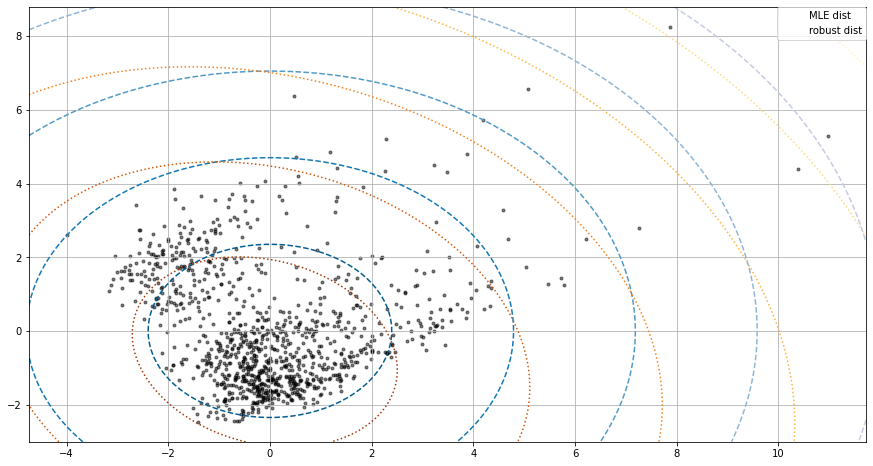

In [176]:
robust_cov = MinCovDet().fit(pca)
#-----------------------------------------------------------------------------
# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(pca)
#-----------------------------------------------------------------------------
# Display results
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.scatter(pca.iloc[:, 0], pca.iloc[:, 1], alpha=.5, color='k', marker='.')
# Show contours of the distance functions
xx, yy = np.meshgrid(np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1],
                                 100),
                     np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1],
                                 100))
zz = np.c_[xx.ravel(), yy.ravel()]
#-----------------------------------------------------------------------------
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = ax1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                              cmap=plt.cm.PuBu_r,
                              linestyles='dashed')
#-----------------------------------------------------------------------------
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                             cmap=plt.cm.YlOrBr_r, linestyles='dotted')
ax1.legend([emp_cov_contour.collections[1], robust_contour.collections[1]],
           ['MLE dist', 'robust dist'],
           loc="upper right", borderaxespad=0)
ax1.grid()

The idea behind the MCD is to find observations whose empirical covariance has the smallest determinant, yielding a “pure” subset of observations from which to compute standards estimates of location and covariance. We have a clear difference between the robust MCD based Mahalanobis distances and MLE based distances.

-----------------

Let's visualize the difference when using localoutlierfactor to detect the outliers based on mahalanobis distace.

In [178]:
X = df.copy()
X['Price'] = np.log(X['Price'])
std = StandardScaler()
X = std.fit_transform(X.drop('Price',axis=1), y=X['Price'])
X = pd.DataFrame(X)

In [179]:
lof = LocalOutlierFactor(n_neighbors=20, metric = 'mahalanobis')
labels = lof.fit_predict(X)

pca = PCA(n_components=2).fit_transform(X)
pca = pd.DataFrame(pca)
pca['labels'] = labels

In [180]:
col_0_in = pca.iloc[:, 0].loc[pca['labels']==1]
col_1_in = pca.iloc[:, 1].loc[pca['labels']==1]
col_0_out = pca.iloc[:, 0].loc[pca['labels']==-1]
col_1_out = pca.iloc[:, 1].loc[pca['labels']==-1]

In [181]:
pca.drop('labels',axis=1, inplace=True)

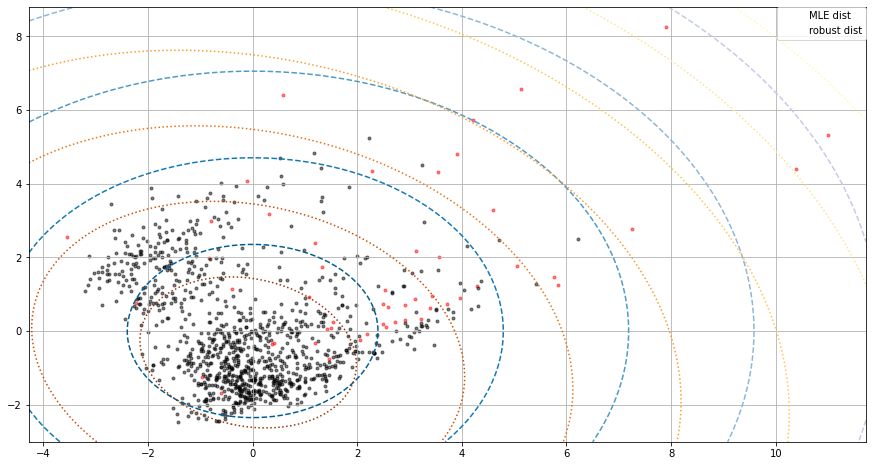

In [182]:
robust_cov = MinCovDet().fit(pca)
#-----------------------------------------------------------------------------
# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(pca)
#-----------------------------------------------------------------------------
# Display results
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.scatter(col_0_out, col_1_out, alpha=.5, color='r', marker='.')
ax1.scatter(col_0_in, col_1_in, alpha=.5, color='k', marker='.')
# Show contours of the distance functions

xx, yy = np.meshgrid(np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1],
                                 100),
                     np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1],
                                 100))
zz = np.c_[xx.ravel(), yy.ravel()]
#-----------------------------------------------------------------------------
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = ax1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                              cmap=plt.cm.PuBu_r,
                              linestyles='dashed')
#-----------------------------------------------------------------------------
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                             cmap=plt.cm.YlOrBr_r, linestyles='dotted')
ax1.legend([emp_cov_contour.collections[1], robust_contour.collections[1]],
           ['MLE dist', 'robust dist'],
           loc="upper right", borderaxespad=0)
ax1.grid()

We have a clear difference between the 2 where MinCovDet is more robust than MLE

# Modeling

## Models

Fitting base model without any feature engineering **RMSE = 383,125** [Section 6](#Vanilla)

Feature importance:

<AxesSubplot:xlabel='importance', ylabel='features'>

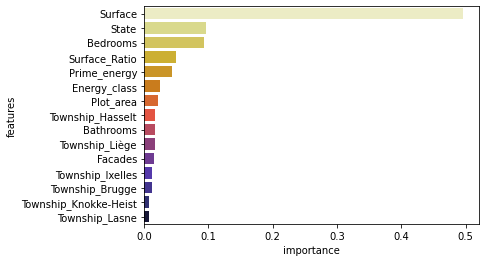

In [100]:
sns.barplot(y = for_viz['features'].iloc[0:15], x = for_viz['importance'].iloc[0:15], palette = "CMRmap_r")

---------------------------

Fitting base model with feat. eng: **RMSE = 297,155**

In [69]:
del df
df = final_df.copy()

In [70]:
y_train=df['Price']
X_train = df.drop(['Price'], axis=1)

In [71]:
clf = DecisionTreeRegressor(random_state=1)
clf.fit(X_train, y_train)
preds=clf.predict(X_test)
print('RMSE:' ,((mean_squared_error(y_test,preds)**0.5)))

RMSE: 297155.03009958775


Feature Importance

In [72]:
feat_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['Score'])
feat_importances = feat_importances.sort_values(by='Score',ascending=False).head(15)

In [73]:
feat_importances

,Score
Surface,0.535061
Distance,0.200704
Plot_area,0.073821
Bathrooms,0.046911
Energy_class,0.039662
Bedrooms,0.028017
Surface_Ratio,0.025480
Facades,0.011507
State,0.010913
Province_East Flanders,0.008041


<AxesSubplot:xlabel='Score'>

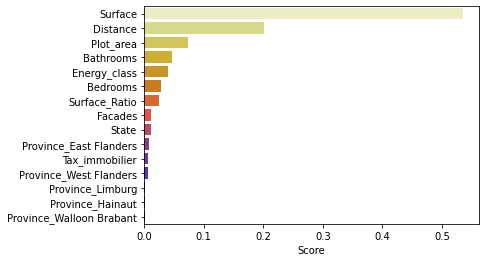

In [74]:
sns.barplot(y = feat_importances.index, x = feat_importances['Score'], palette = "CMRmap_r")

## Parameter tuning

--------------

In [75]:
y_train=df['Price'].copy()
X_train = df.drop('Price',axis=1)

In [76]:
param_grid = {'clf__max_depth': range(5,50,5),
 'clf__max_leaf_nodes': range(5,50),
 'clf__min_samples_leaf':range(0,20),
 'clf__min_samples_split': range(5,15)}

In [ ]:
pipeline = Pipeline(steps=[
                           ('clf', DecisionTreeRegressor(random_state=1))
                                 ])
grid_clf_acc = GridSearchCV(pipeline, param_grid, cv=5,scoring='neg_mean_squared_error', n_jobs=-1)
grid_clf_acc.fit(X_train,y_train)

In [ ]:
grid_clf_acc = GridSearchCV(pipeline, param_grid, cv=5,scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
grid_clf_acc.best_params_ 

In [ ]:
preds= grid_clf_acc.predict(X_train)
print('RMSE:' ,(mean_squared_error(y_train,preds)**0.5))

In [ ]:
print('R-squared:',r2_score(y_train,preds))

In [ ]:
preds= grid_clf_acc.predict(X_test)
print('RMSE:' ,(mean_squared_error(y_test,preds)**0.5))

In [ ]:
sns.barplot(y = X_train.columns, x = grid_clf_acc.best_estimator_.named_steps["clf"].feature_importances_, palette = "CMRmap_r")

In [77]:
clf = DecisionTreeRegressor(random_state=1,max_depth=10,max_leaf_nodes=40,min_samples_leaf=5,min_samples_split=11)
clf.fit(X_train, y_train)
preds=clf.predict(X_test)
print('RMSE:' ,((mean_squared_error(y_test,preds)**0.5)))

RMSE: 273469.48507839744


In [78]:
feat_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['Score'])
feat_importances = feat_importances.sort_values(by='Score',ascending=False).head(15)

<AxesSubplot:xlabel='Score'>

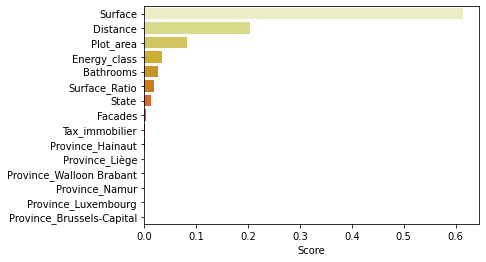

In [79]:
sns.barplot(y = feat_importances.index, x = feat_importances['Score'], palette = "CMRmap_r")

Plot tree:

In [80]:
clf = DecisionTreeRegressor(random_state=1,max_depth=10,max_leaf_nodes=40,min_samples_leaf=5,min_samples_split=11)
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=40, min_samples_leaf=5,
                      min_samples_split=11, random_state=1)

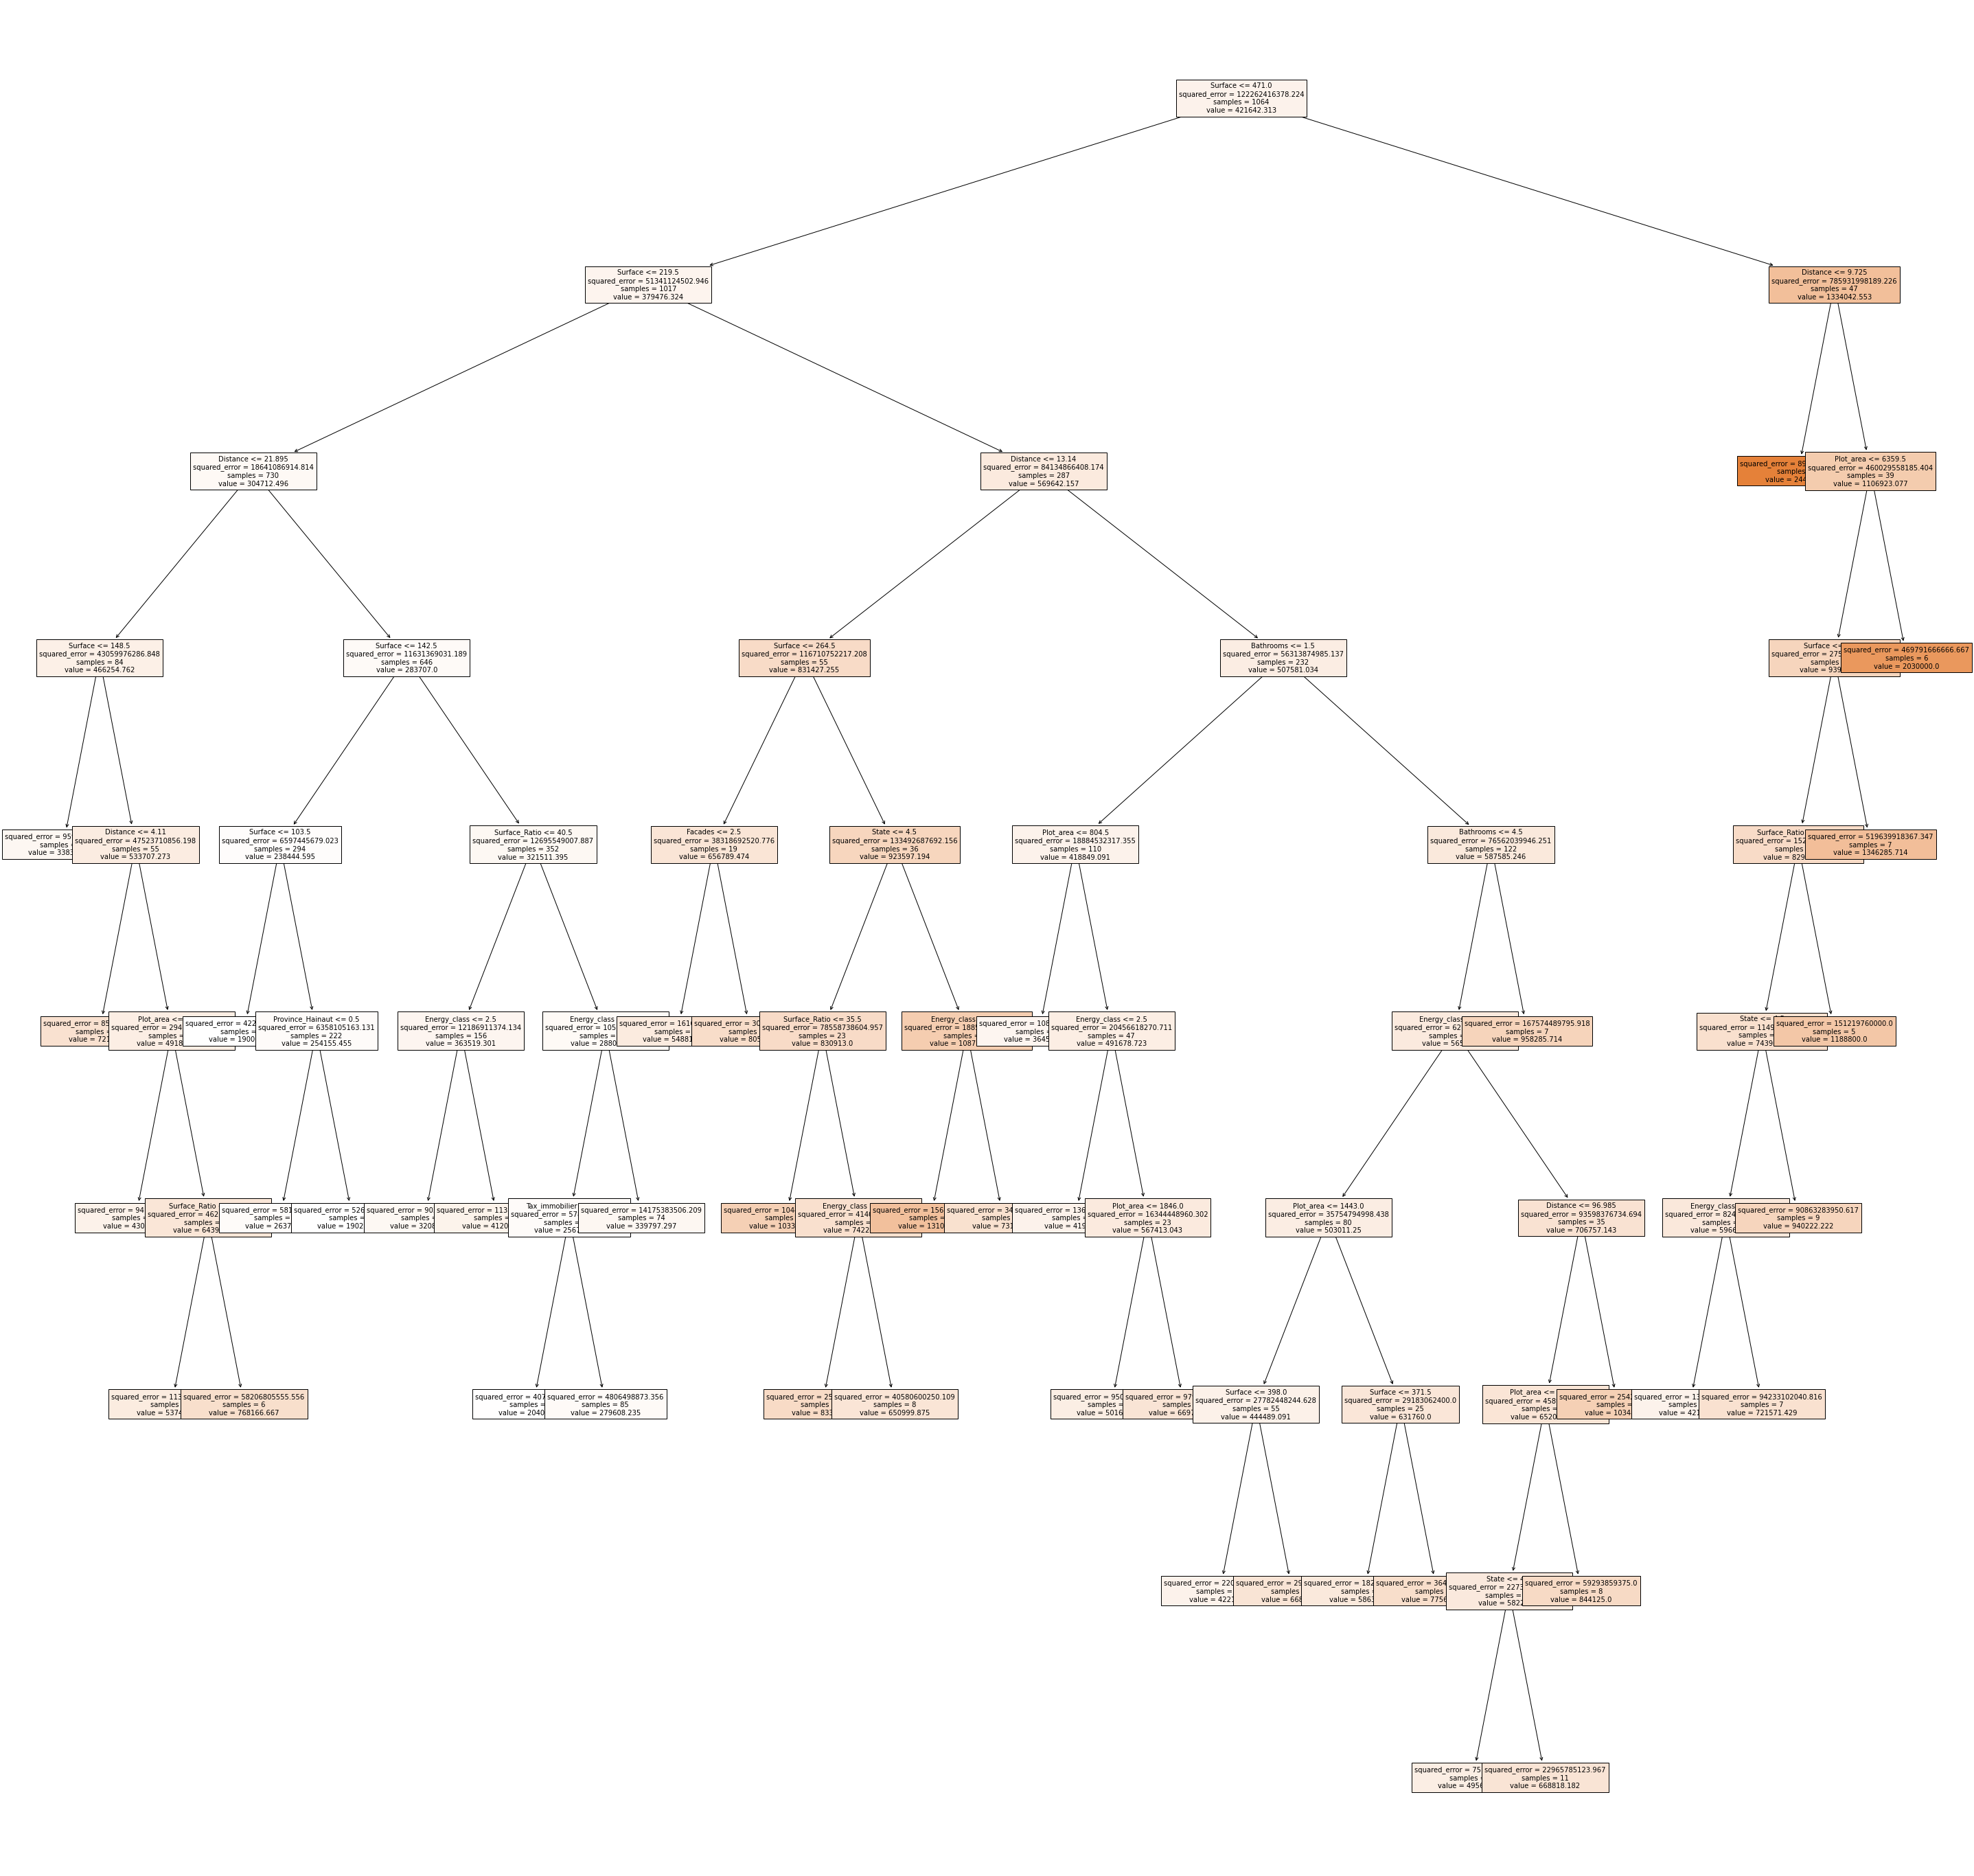

In [81]:
plt.figure(figsize=(50,50))

tree.plot_tree(clf,max_depth=10,feature_names=X_train.columns.tolist(),filled=True,fontsize=10)
plt.show()

# Vanilla

In [82]:
df2 = pd.read_excel('houses.xlsx', index_col=0)

In [83]:
df2.head()

,State of the building,Number of facades,Habitable surface,Bedrooms,Bathrooms,Area of ​​the plot,Primary energy consumption,"Gas, water & electricity",Energy class,Heating type,Double glass,Price,Zip code,Township
6,To renovate,3,211,3,1,396,466.0,Yes,E,NaN,Yes,296000,9700,Oudenaarde
7,Excellent state,2,210,4,1,267,212.0,Yes,C,Gas,Yes,279000,9700,Oudenaarde
51,To renovate,3,280,4,2,880,576.0,No,G,Oil fuel,Yes,1350000,1060,Saint-Gilles
52,Good,2,180,4,1,182,358.0,Yes,D,Gas,NaN,399000,2000,Antwerpen
55,Good,2,105,2,1,336,247.0,Yes,C,Gas,Yes,279000,2000,Antwerpen


In [84]:
df2.reset_index(inplace=True,drop=True)
mynewcolumns= ['State', 'Facades','Surface','Bedrooms','Bathrooms','Plot_area',
 'Prime_energy','Utilities','Energy_class','Heating','Double_glass','Price','Zip','Township']
mynewindex= [ 'State', 'Facades','Bedrooms','Bathrooms','Utilities','Energy_class',
 'Heating','Double_glass','Zip','Township','Surface','Plot_area', 'Prime_energy','Price']
df2.columns = mynewcolumns
df2 = df2[mynewindex]

In [85]:
df2.drop('Zip', axis=1,inplace=True)

In [86]:
df2

,State,Facades,Bedrooms,Bathrooms,Utilities,Energy_class,Heating,Double_glass,Township,Surface,Plot_area,Prime_energy,Price
0,To renovate,3,3,1,Yes,E,NaN,Yes,Oudenaarde,211,396,466.0,296000
1,Excellent state,2,4,1,Yes,C,Gas,Yes,Oudenaarde,210,267,212.0,279000
2,To renovate,3,4,2,No,G,Oil fuel,Yes,Saint-Gilles,280,880,576.0,1350000
3,Good,2,4,1,Yes,D,Gas,NaN,Antwerpen,180,182,358.0,399000
4,Good,2,2,1,Yes,C,Gas,Yes,Antwerpen,105,336,247.0,279000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,Excellent state,4,2,1,Yes,C,Gas,Yes,Schilde,80,792,286.0,339000
1327,Excellent state,2,3,1,Yes,D,Gas,Yes,Waregem,112,87,341.0,209000
1328,To refresh,2,4,1,No,C,Oil fuel,Yes,Waterloo,120,689,172.0,295000
1329,Just renovated,2,2,1,Yes,D,Pellets,Yes,Neufchateau,156,1,337.0,160000


In [87]:
#Impute missing values
df2["Double_glass"] = df2["Double_glass"].fillna("None")
df2["Heating"] = df2["Heating"].fillna("None")
## Change the plot area = to surface if livable surface is greater than plot area
df2['Surface_Ratio']  = df2['Surface'] / df2['Plot_area'] 
df2['Surface_Ratio'] = df2['Surface_Ratio'].apply(lambda x: round(x,2)*100)
df2['Plot_area'] = np.where(df2['Plot_area']<df2['Surface'], df2['Surface'], df2['Plot_area'])
# Change the energy classes to letters only
df2['Energy_class'].replace({'A+':'A','E_D':'E','D_C':'C'}, inplace=True)

In [88]:
mapper1 = {'A':6 , 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
mapper2 = {'Excellent state':5 , 'Good': 4, 'Just renovated': 3, 'To refresh': 2, 'To renovate': 1, 'To restore': 0}

df2['Energy_class'].replace(mapper1, inplace=True)
df2['State'].replace(mapper2, inplace=True)

In [89]:
df2 = pd.get_dummies(df2, columns=['Heating','Utilities','Township','Double_glass'],drop_first=True)

In [90]:
X=df2.drop(['Price'],axis=1)
y=((df2['Price']))

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10,shuffle=True)

In [92]:
clf = DecisionTreeRegressor(random_state=1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print('RMSE:' ,((mean_squared_error(y_test,clf.predict(X_test))**0.5)))

RMSE: 383125.26530990686


In [96]:
for_viz = pd.DataFrame()
for_viz['features']= pd.DataFrame(X_train.columns)
for_viz['importance'] =  pd.DataFrame(clf.feature_importances_)

In [97]:
for_viz = for_viz.sort_values('importance',ascending = False)

In [98]:
for_viz.head(10)

,features,importance
5,Surface,0.495594
0,State,0.096022
2,Bedrooms,0.093307
8,Surface_Ratio,0.049415
7,Prime_energy,0.043939
4,Energy_class,0.025487
6,Plot_area,0.021129
135,Township_Hasselt,0.017742
3,Bathrooms,0.017204
194,Township_Liège,0.016326


<AxesSubplot:xlabel='importance', ylabel='features'>

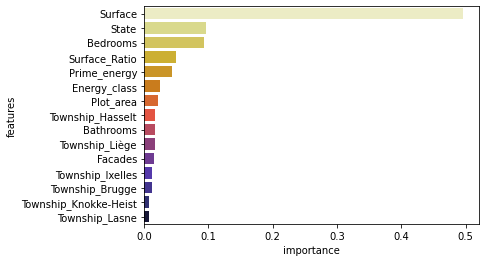

In [99]:
sns.barplot(y = for_viz['features'].iloc[0:15], x = for_viz['importance'].iloc[0:15], palette = "CMRmap_r")